In [ ]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import nltk
import nltk
from tensorflow.keras.regularizers import l2
nltk.download('punkt')
nltk.download('stopwords')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_1 = pd.read_csv("/content/drive/MyDrive/bangla sarc/SarcasDetectionEDA[1].csv")
data_2 = pd.read_csv("/content/drive/MyDrive/bangla sarc/SarcasDetection[1].csv")
data =  pd.concat([data_1, data_2])
data.head()

,Unnamed: 0,Comments,Label,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,0,আমি মনে করি যখন মেয়েরা উদ্দেশ্য অনুসারে বোবা ...,1.0,16.0,13.0,0.0,0.0,4.1875,82.0,0.0,0.0,0.0
1,1,আমি যখন কোনও গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা করি ...,1.0,37.0,20.0,0.0,0.0,4.0000,184.0,0.0,0.0,0.0
2,2,বাহ ... আমি দেখতে দেখতে পাচ্ছি সত্যিই দোষী দোষ...,1.0,10.0,8.0,0.0,0.0,5.7000,66.0,4.0,1.0,0.0
3,3,"হাহ, মজার বিষয়।#আনোয়েড #গ্রুআপ",1.0,4.0,4.0,0.0,0.0,7.2500,32.0,3.0,2.0,0.0
4,4,থান্ডার আমাকে 830 এ জেগে উঠলে এটি ভালবাসুন,1.0,8.0,8.0,0.0,0.0,4.3750,42.0,0.0,0.0,0.0


In [ ]:
import re

def clean_bangla_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = url_pattern.sub('', text)

    # Remove mentions (e.g., @username)
    text = " ".join(filter(lambda x: x[0] != '@', text.split()))

    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001FFFF"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove punctuation (Bengali and English)
    punctuation_pattern = re.compile(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=।-]", re.UNICODE)
    text = punctuation_pattern.sub('', text)

    return text

def bangla_tokenizer(text):
    # First clean the text
    text = clean_bangla_text(text)

    # Tokenize by splitting on whitespace
    tokens = text.split()

    return tokens


In [ ]:
# Apply cleaning to the 'Comments' column
data['Cleaned_Comments'] = data['Comments'].apply(clean_bangla_text)

# Apply tokenization to the cleaned comments
data['Tokenized_Comments'] = data['Cleaned_Comments'].apply(bangla_tokenizer)

# Display the first few rows of the dataset to see the results
print(data[['Comments', 'Cleaned_Comments', 'Tokenized_Comments']].head())


                                            Comments  \
0  আমি মনে করি যখন মেয়েরা উদ্দেশ্য অনুসারে বোবা ...   
1  আমি যখন কোনও গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা করি ...   
2  বাহ ... আমি দেখতে দেখতে পাচ্ছি সত্যিই দোষী দোষ...   
3                   হাহ, মজার বিষয়।#আনোয়েড #গ্রুআপ   
4         থান্ডার আমাকে 830 এ জেগে উঠলে এটি ভালবাসুন   

                                    Cleaned_Comments  \
0  আমি মনে করি যখন মেয়েরা উদ্দেশ্য অনুসারে বোবা ...   
1  আমি যখন কোনও গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা করি ...   
2  বাহ  আমি দেখতে দেখতে পাচ্ছি সত্যিই দোষী দোষী স...   
3                       হাহ মজার বিষয়আনোয়েড গ্রুআপ   
4         থান্ডার আমাকে 830 এ জেগে উঠলে এটি ভালবাসুন   

                                  Tokenized_Comments  
0  [আমি, মনে, করি, যখন, মেয়েরা, উদ্দেশ্য, অনুসার...  
1  [আমি, যখন, কোনও, গুরুত্বপূর্ণ, প্রশ্ন, জিজ্ঞাস...  
2  [বাহ, আমি, দেখতে, দেখতে, পাচ্ছি, সত্যিই, দোষী,...  
3                  [হাহ, মজার, বিষয়আনোয়েড, গ্রুআপ]  
4  [থান্ডার, আমাকে, 830, এ, জেগে, উঠলে, এটি, ভালব..

**train test split**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming you have already applied the cleaning and tokenization to the dataset
# data['Cleaned_Comments'] and data['Tokenized_Comments'] columns should be ready

# Define parameters
validation_split = 0.2
max_length = 25

# Prepare the text data for tokenization
tokenized_comments = data['Tokenized_Comments'].apply(lambda x: ' '.join(x)).tolist()

# Initialize and fit the tokenizer
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tokenized_comments)

# Convert the text to sequences of integers
sequences = tokenizer_obj.texts_to_sequences(tokenized_comments)

# Get the word index and vocabulary size
word_index = tokenizer_obj.word_index
print("Unique tokens:", len(word_index))
vocab_size = len(word_index) + 1
print('Vocabulary size:', vocab_size)

# Pad the sequences to ensure uniform input length
comments_pad = pad_sequences(sequences, maxlen=max_length, padding='post')

# Prepare the labels
labels = data['Label'].values

# Shuffle the data and labels
indices = np.arange(comments_pad.shape[0])
np.random.shuffle(indices)
comments_pad = comments_pad[indices]
labels = labels[indices]

# Calculate the number of validation samples
num_validation_samples = int(validation_split * comments_pad.shape[0])

# Split the data into training and test sets
X_train_pad = comments_pad[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_test_pad = comments_pad[-num_validation_samples:]
y_test = labels[-num_validation_samples:]

# Print the shapes to verify
print("Training data shape:", X_train_pad.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test_pad.shape)
print("Testing labels shape:", y_test.shape)



Unique tokens: 12515
Vocabulary size: 12516
Training data shape: (8180, 25)
Training labels shape: (8180,)
Testing data shape: (2044, 25)
Testing labels shape: (2044,)


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# Sample data loading (ensure the data is loaded correctly)
data_1 = pd.read_csv("/content/drive/MyDrive/bangla sarc/SarcasDetectionEDA[1].csv")
data_2 = pd.read_csv("/content/drive/MyDrive/bangla sarc/SarcasDetection[1].csv")
data = pd.concat([data_1, data_2])

# Ensure that the cleaning function is defined
def clean_bangla_text(text):
    text = text.lower()
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = url_pattern.sub('', text)
    text = " ".join(filter(lambda x: x[0] != '@', text.split()))
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001FFFF"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    punctuation_pattern = re.compile(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=।-]", re.UNICODE)
    text = punctuation_pattern.sub('', text)
    return text

# Apply cleaning to the 'Comments' column
data['Cleaned_Comments'] = data['Comments'].apply(clean_bangla_text)

# Tokenization
def bangla_tokenizer(text):
    return text.split()

# Apply tokenization to the cleaned comments
data['Tokenized_Comments'] = data['Cleaned_Comments'].apply(bangla_tokenizer)

# Ensure Tokenized_Comments column is properly created
print(data[['Cleaned_Comments', 'Tokenized_Comments']].head())

# Define parameters for train-test split
validation_split = 0.2
max_length = 25

# Prepare the text data for tokenization
tokenized_comments = data['Tokenized_Comments'].apply(lambda x: ' '.join(x)).tolist()

# Initialize and fit the tokenizer
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tokenized_comments)

# Convert the text to sequences of integers
sequences = tokenizer_obj.texts_to_sequences(tokenized_comments)

# Get the word index and vocabulary size
word_index = tokenizer_obj.word_index
print("Unique tokens:", len(word_index))
vocab_size = len(word_index) + 1
print('Vocabulary size:', vocab_size)

# Pad the sequences to ensure uniform input length
comments_pad = pad_sequences(sequences, maxlen=max_length, padding='post')

# Prepare the labels
labels = data['Label'].values

# Shuffle the data and labels
indices = np.arange(comments_pad.shape[0])
np.random.shuffle(indices)
comments_pad = comments_pad[indices]
labels = labels[indices]

# Calculate the number of validation samples
num_validation_samples = int(validation_split * comments_pad.shape[0])

# Split the data into training and test sets
X_train_pad = comments_pad[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_test_pad = comments_pad[-num_validation_samples:]
y_test = labels[-num_validation_samples:]

# Print the shapes to verify
print("Training data shape:", X_train_pad.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test_pad.shape)
print("Testing labels shape:", y_test.shape)


                                    Cleaned_Comments  \
0  আমি মনে করি যখন মেয়েরা উদ্দেশ্য অনুসারে বোবা ...   
1  আমি যখন কোনও গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা করি ...   
2  বাহ  আমি দেখতে দেখতে পাচ্ছি সত্যিই দোষী দোষী স...   
3                       হাহ মজার বিষয়আনোয়েড গ্রুআপ   
4         থান্ডার আমাকে 830 এ জেগে উঠলে এটি ভালবাসুন   

                                  Tokenized_Comments  
0  [আমি, মনে, করি, যখন, মেয়েরা, উদ্দেশ্য, অনুসার...  
1  [আমি, যখন, কোনও, গুরুত্বপূর্ণ, প্রশ্ন, জিজ্ঞাস...  
2  [বাহ, আমি, দেখতে, দেখতে, পাচ্ছি, সত্যিই, দোষী,...  
3                  [হাহ, মজার, বিষয়আনোয়েড, গ্রুআপ]  
4  [থান্ডার, আমাকে, 830, এ, জেগে, উঠলে, এটি, ভালব...  
Unique tokens: 12515
Vocabulary size: 12516
Training data shape: (8180, 25)
Training labels shape: (8180,)
Testing data shape: (2044, 25)
Testing labels shape: (2044,)


In [ ]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (8180, 25)
Shape of y_train: (8180,)
Shape of X_test_pad: (2044, 25)
Shape of y_test: (2044,)


In [ ]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec

# Train Word2Vec model on the tokenized comments
embedding_dim = 100  # You can adjust this dimension as per your requirement
word2vec_model = Word2Vec(sentences=data['Tokenized_Comments'], vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Create an embedding matrix where each word in the tokenizer's word_index is mapped to the Word2Vec vector
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        # If the word is not in Word2Vec vocabulary, leave the corresponding row as zeros
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (12516, 100)


**model 1 trial **

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, concatenate, GlobalAveragePooling1D

# Input layer
input_layer = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)(input_layer)

# BiLSTM layer
lstm_output = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.25, return_sequences=True))(embedding_layer)

# GRU layer
gru_output = GRU(256, dropout=0.2, recurrent_dropout=0.25, return_sequences=True)(lstm_output)

# Concatenate BiLSTM and GRU outputs
concatenated_output = concatenate([lstm_output, gru_output])

# Apply a pooling layer to reduce the sequence dimension
pooled_output = GlobalAveragePooling1D()(concatenated_output)

# Dense layer
dense_layer = Dense(1, activation='sigmoid')(pooled_output)

# Define the model
model = Model(inputs=input_layer, outputs=dense_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_test_pad, y_test),
                    verbose=2)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 25)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 25, 100)        │      1,251,600 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 25, 512)        │        731,136 │ embedding_3[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ (None, 25, 256)        │        591,360 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 25, 768)        │              0 │ bidirectional_2[0][0], │
│ (Concatenate)             │                        │                │ gru_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ concatenate_2[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            769 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,574,865 (9.82 MB)

 Trainable params: 1,323,265 (5.05 MB)

 Non-trainable params: 1,251,600 (4.77 MB)

Epoch 1/10
128/128 - 25s - 197ms/step - accuracy: 0.7771 - loss: 0.4837 - val_accuracy: 0.8302 - val_loss: 0.3744
Epoch 2/10
128/128 - 18s - 142ms/step - accuracy: 0.8209 - loss: 0.4114 - val_accuracy: 0.8219 - val_loss: 0.4047
Epoch 3/10
128/128 - 21s - 164ms/step - accuracy: 0.8291 - loss: 0.3853 - val_accuracy: 0.8386 - val_loss: 0.3548
Epoch 4/10
128/128 - 20s - 156ms/step - accuracy: 0.8329 - loss: 0.3849 - val_accuracy: 0.8386 - val_loss: 0.3666
Epoch 5/10
128/128 - 21s - 163ms/step - accuracy: 0.8388 - loss: 0.3748 - val_accuracy: 0.8371 - val_loss: 0.3688
Epoch 6/10
128/128 - 17s - 132ms/step - accuracy: 0.8458 - loss: 0.3593 - val_accuracy: 0.8508 - val_loss: 0.3660
Epoch 7/10
128/128 - 21s - 167ms/step - accuracy: 0.8458 - loss: 0.3571 - val_accuracy: 0.8488 - val_loss: 0.3580
Epoch 8/10
128/128 - 20s - 156ms/step - accuracy: 0.8522 - loss: 0.3473 - val_accuracy: 0.8474 - val_loss: 0.3520
Epoch 9/10
128/128 - 21s - 164ms/step - accuracy: 0.8516 - loss: 0.3454 - val_accuracy: 

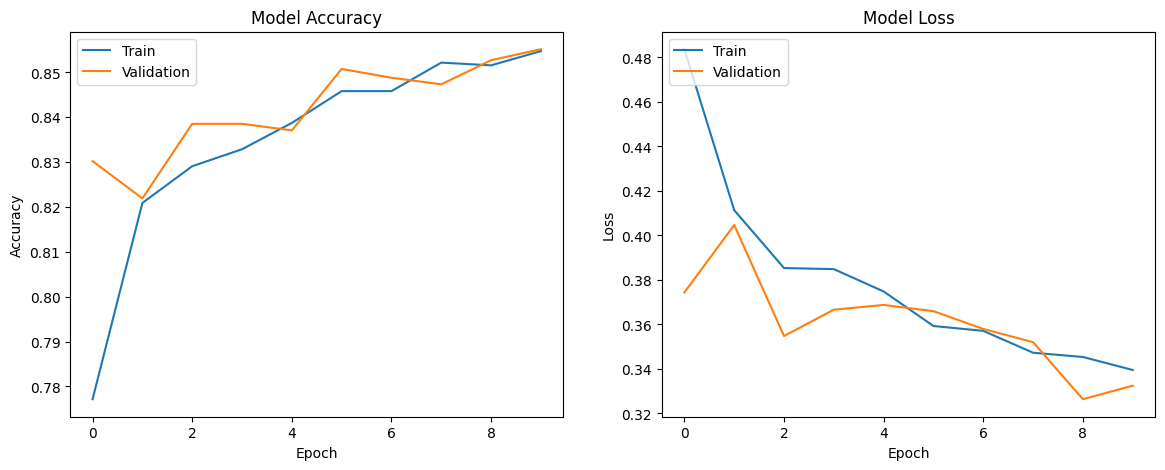

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Predict the classes on the test data
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred_classes)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred_classes)
print(f'Recall: {recall:.4f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Generate a classification report (includes precision, recall, f1-score)
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step
Accuracy: 0.8552
Precision: 0.8839
Recall: 0.7137
Confusion Matrix:
[[1192   73]
 [ 223  556]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      1265
         1.0       0.88      0.71      0.79       779

    accuracy                           0.86      2044
   macro avg       0.86      0.83      0.84      2044
weighted avg       0.86      0.86      0.85      2044



 **Model 1 final trial **

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, concatenate, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

# Input layer
input_layer = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)(input_layer)

# BiLSTM layer
lstm_output = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.25, return_sequences=True))(embedding_layer)

# GRU layer
gru_output = GRU(256, dropout=0.2, recurrent_dropout=0.25, return_sequences=True)(lstm_output)

# Concatenate BiLSTM and GRU outputs
concatenated_output = concatenate([lstm_output, gru_output])

# Apply a pooling layer to reduce the sequence dimension
pooled_output = GlobalAveragePooling1D()(concatenated_output)

# Dense layer
dense_layer = Dense(1, activation='sigmoid')(pooled_output)

# Define the model
model = Model(inputs=input_layer, outputs=dense_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Checkpoint callback to save the model after every epoch
epoch_checkpoint_filepath = '/content/drive/MyDrive/bangla_sarc/bangla_sarcasm_detection_epoch_{epoch:02d}.keras'
epoch_checkpoint_callback = ModelCheckpoint(filepath=epoch_checkpoint_filepath,
                                            save_freq='epoch',
                                            save_weights_only=False,
                                            monitor='val_loss',
                                            mode='min',
                                            verbose=1)

# Checkpoint callback to save the best model
best_model_filepath = '/content/drive/MyDrive/bangla_sarc/best_model_bangla.keras'
best_model_checkpoint_callback = ModelCheckpoint(filepath=best_model_filepath,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 verbose=1)

# Train the model with checkpointing for both the best model and after every epoch
history = model.fit(X_train_pad, y_train,
                    epochs=35,
                    batch_size=32,
                    validation_data=(X_test_pad, y_test),
                    callbacks=[epoch_checkpoint_callback, best_model_checkpoint_callback],
                    verbose=2)

# To load the best model later
# from tensorflow.keras.models import load_model
# best_model = load_model('/content/drive/MyDrive/bangla_sarc/best_model_bangla.keras')

# To load a specific epoch model later
# epoch_model = load_model('/content/drive/MyDrive/bangla_sarc/bangla_sarcasm_detection_epoch_XX.keras')  # Replace XX with the epoch number you want to load


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 25)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 25, 100)        │      1,251,600 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 25, 512)        │        731,136 │ embedding_6[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_5 (GRU)               │ (None, 25, 256)        │        591,360 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 25, 768)        │              0 │ bidirectional_5[0][0], │
│ (Concatenate)             │                        │                │ gru_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ concatenate_5[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │            769 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,574,865 (9.82 MB)

 Trainable params: 1,323,265 (5.05 MB)

 Non-trainable params: 1,251,600 (4.77 MB)

Epoch 1/35

Epoch 1: saving model to /content/drive/MyDrive/bangla_sarc/bangla_sarcasm_detection_epoch_01.keras

Epoch 1: val_accuracy improved from -inf to 0.81996, saving model to /content/drive/MyDrive/bangla_sarc/best_model_bangla.keras
256/256 - 45s - 177ms/step - accuracy: 0.7858 - loss: 0.4781 - val_accuracy: 0.8200 - val_loss: 0.4037
Epoch 2/35

Epoch 2: saving model to /content/drive/MyDrive/bangla_sarc/bangla_sarcasm_detection_epoch_02.keras

Epoch 2: val_accuracy improved from 0.81996 to 0.83072, saving model to /content/drive/MyDrive/bangla_sarc/best_model_bangla.keras
256/256 - 41s - 160ms/step - accuracy: 0.8205 - loss: 0.4073 - val_accuracy: 0.8307 - val_loss: 0.3716
Epoch 3/35

Epoch 3: saving model to /content/drive/MyDrive/bangla_sarc/bangla_sarcasm_detection_epoch_03.keras

Epoch 3: val_accuracy improved from 0.83072 to 0.83415, saving model to /content/drive/MyDrive/bangla_sarc/best_model_bangla.keras
256/256 - 41s - 160ms/step - accuracy: 0.8312 - loss: 0.3901 - va

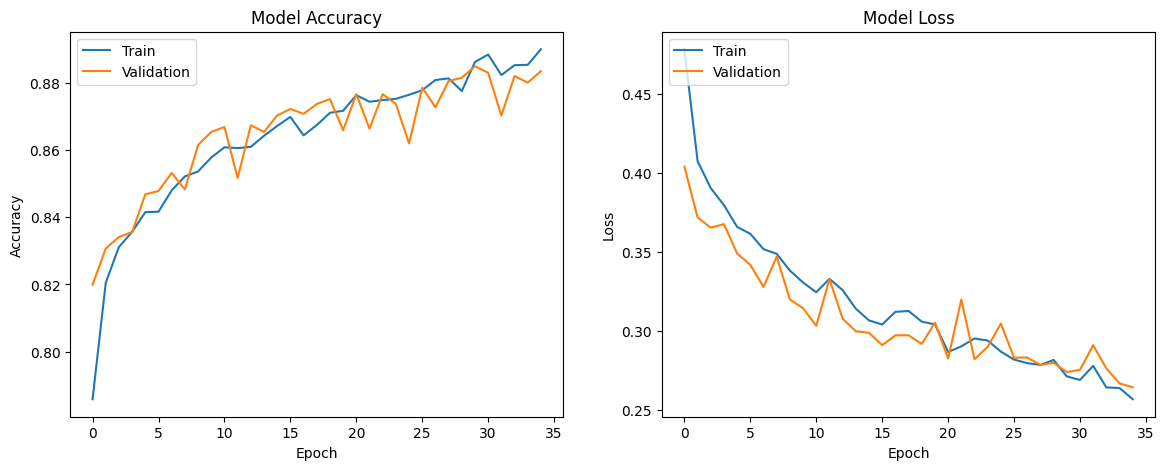

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Predict the classes on the test data
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred_classes)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred_classes)
print(f'Recall: {recall:.4f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Generate a classification report (includes precision, recall, f1-score)
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step
Accuracy: 0.8836
Precision: 0.9031
Recall: 0.7779
Confusion Matrix:
[[1200   65]
 [ 173  606]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      1265
         1.0       0.90      0.78      0.84       779

    accuracy                           0.88      2044
   macro avg       0.89      0.86      0.87      2044
weighted avg       0.89      0.88      0.88      2044



***model final 2***

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, concatenate, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

# Input layer
input_layer = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)(input_layer)

# BiLSTM layer
lstm_output = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.25, return_sequences=True))(embedding_layer)

# GRU layer
gru_output = GRU(256, dropout=0.2, recurrent_dropout=0.25, return_sequences=True)(lstm_output)

# Concatenate BiLSTM and GRU outputs
concatenated_output = concatenate([lstm_output, gru_output])

# Apply a pooling layer to reduce the sequence dimension
pooled_output = GlobalAveragePooling1D()(concatenated_output)

# Dense layer
dense_layer = Dense(1, activation='sigmoid')(pooled_output)

# Define the model
model = Model(inputs=input_layer, outputs=dense_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Checkpoint callback to save the model after every epoch
epoch_checkpoint_filepath = '/content/drive/MyDrive/bangla_sarc/bangla_sarcasm_detection_epoch_{epoch:02d}.keras'
epoch_checkpoint_callback = ModelCheckpoint(filepath=epoch_checkpoint_filepath,
                                            save_freq='epoch',
                                            save_weights_only=False,
                                            monitor='val_loss',
                                            mode='min',
                                            verbose=1)

# Checkpoint callback to save the best model
best_model_filepath = '/content/drive/MyDrive/bangla_sarc/best_model_bangla.keras'
best_model_checkpoint_callback = ModelCheckpoint(filepath=best_model_filepath,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 verbose=1)

# Train the model with checkpointing for both the best model and after every epoch
history = model.fit(X_train_pad, y_train,
                    epochs=35,
                    batch_size=32,
                    validation_data=(X_test_pad, y_test),
                    callbacks=[epoch_checkpoint_callback, best_model_checkpoint_callback],
                    verbose=2)

# To load the best model later
# from tensorflow.keras.models import load_model
# best_model = load_model('/content/drive/MyDrive/bangla_sarc/best_model_bangla.keras')

# To load a specific epoch model later
# epoch_model = load_model('/content/drive/MyDrive/bangla_sarc/bangla_sarcasm_detection_epoch_XX.keras')  # Replace XX with the epoch number you want to load


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 25)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 25, 100)        │      1,251,600 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 25, 512)        │        731,136 │ embedding_7[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_6 (GRU)               │ (None, 25, 256)        │        591,360 │ bidirectional_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 25, 768)        │              0 │ bidirectional_6[0][0], │
│ (Concatenate)             │                        │                │ gru_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ concatenate_6[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │            769 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,574,865 (9.82 MB)

 Trainable params: 1,323,265 (5.05 MB)

 Non-trainable params: 1,251,600 (4.77 MB)

Epoch 1/35

Epoch 1: saving model to /content/drive/MyDrive/bangla_sarc/bangla_sarcasm_detection_epoch_01.keras

Epoch 1: val_accuracy improved from -inf to 0.77984, saving model to /content/drive/MyDrive/bangla_sarc/best_model_bangla.keras
256/256 - 41s - 162ms/step - accuracy: 0.7957 - loss: 0.4560 - val_accuracy: 0.7798 - val_loss: 0.4794
Epoch 2/35

Epoch 2: saving model to /content/drive/MyDrive/bangla_sarc/bangla_sarcasm_detection_epoch_02.keras

Epoch 2: val_accuracy improved from 0.77984 to 0.83268, saving model to /content/drive/MyDrive/bangla_sarc/best_model_bangla.keras
256/256 - 36s - 142ms/step - accuracy: 0.8199 - loss: 0.4086 - val_accuracy: 0.8327 - val_loss: 0.3722
Epoch 3/35

Epoch 3: saving model to /content/drive/MyDrive/bangla_sarc/bangla_sarcasm_detection_epoch_03.keras

Epoch 3: val_accuracy improved from 0.83268 to 0.83513, saving model to /content/drive/MyDrive/bangla_sarc/best_model_bangla.keras
256/256 - 38s - 147ms/step - accuracy: 0.8289 - loss: 0.3936 - va

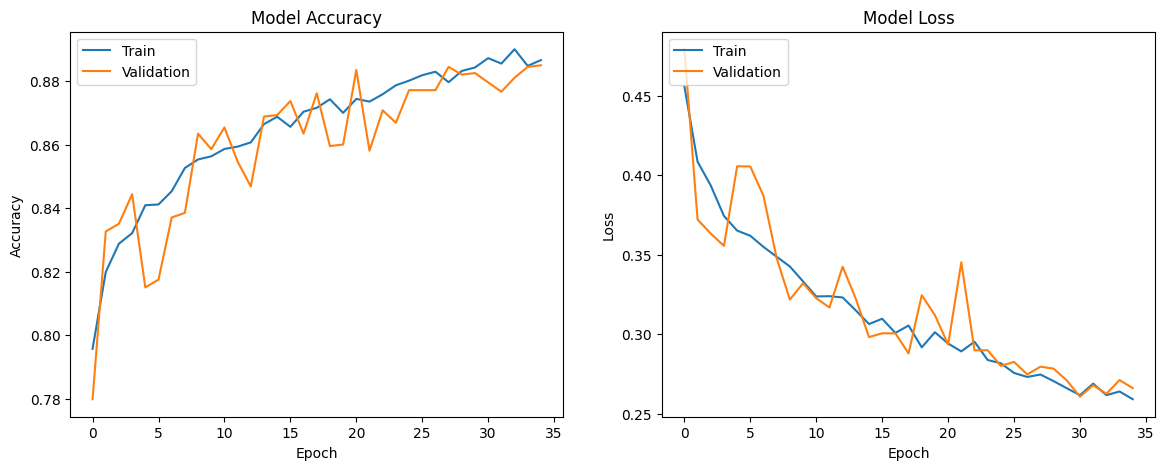

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Predict the classes on the test data
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred_classes)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred_classes)
print(f'Recall: {recall:.4f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Generate a classification report (includes precision, recall, f1-score)
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Accuracy: 0.8850
Precision: 0.9024
Recall: 0.7831
Confusion Matrix:
[[1199   66]
 [ 169  610]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      1265
         1.0       0.90      0.78      0.84       779

    accuracy                           0.89      2044
   macro avg       0.89      0.87      0.87      2044
weighted avg       0.89      0.89      0.88      2044

